# Exercise 10.1
Download the road network of La Spezia (Italy) from OSMWebWizard: </br>
1. Create a python function that, given a list of tuples in the form (type, n_vehicles, edge_list, departure_time) creates an xml file describing the corresponding traffic demand; use the script to compute the traffic demand for the following points. Type can be route or flow.
2. Create a traffic demand of 1,000 vehicles moving through a random origin and destination edges. Ensure that origin and destination are connected. Departure time is chosen uniformly at random in [0, 600].
3. Apply duarouter to the mobility demand for w=1, 5, 10, 15, 20. Compute, for each value of w, the total distance traveled, the difference with respect to the shortest path, and the total CO2 emissions.
* Submit a (well commented) python notebook and the SUMO files.

# Writing the function

In [1]:
def write_traffic_demand(parameters, file_name = 'traffic_demand.xml'):
    """
    Write a xml file with the traffic demand from the following parameters input:
    -traffic_type: either flow or route
    -n_vehicles: n° of vehicles that should be present in the simulations
    -edge_list: edges through which the vehicles should pass from, to and through
    -departure_time: a callable which returns the departure time of the single vehicle

    The parameters should be input as a tuple.
    """

    # Creating the base string structure of the xml
    traffic_base = """<?xml version="1.0" encoding="UTF-8"?>
    <routes xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:noNamespaceSchemaLocation="http://sumo.dlr.de/xsd/routes_file.xsd">
    \t{vtype_vehicle}
    \t<!-- FLOWS -->
    \t{flows}
    \t<!-- VEHICLES -->
    \t{vehicles}
    </routes>
    """.replace('    ', '')

    # unpack the parameters
    traffic_type, n_vehicles, edge_list, departure_time = parameters

    assert callable(departure_time), \
    """A callable with two parameters must be the departure time input.
    e.g.: lambda x: 100 -> To set a constant departure time of 100.
          lambda x: int(np.random.uniform(0, 600) // 1) -> To set a random instantiation of departure time between time 0 and 600.
    It is intended to work with random.randint, so that the range of possible integers will be betwee 0 and 600
    """.replace('    ', '')

    edge_list = [str(x) for x in edge_list]

    # I will use only cars as vehicles
    color_list = ['red', 'blue', 'orange', 'yellow']

    # setting the index and class of vehicle
    vtype_id = 'type1'
    vtype_vehicle = f'<vType id="{vtype_id}" accel="0.8" decel="4.5" sigma="0.5" length="5" maxSpeed="70"/>'

    flows = ''
    vehicles = ''

    if traffic_type == 'flow':

          flow_list = list()
          for flow_id in range(n_vehicles):
              # setting so that color are always the 4 color I set
              color_idx = flow_id - (len(color_list) * ( flow_id // (len(color_list)) ))
              color = color_list[color_idx]

              # setting the starting and ending time of the flow
              depart = departure_time()
              flow_time = f'\n\t<flow id="{flow_id}" begin="{depart}" end="1000" '

              # setting the flow n° of vehicles, origin and destination
              flow_move = f'number="1" from="{edge_list[0]}" to="{edge_list[-1]}" '

              # deleting origin and destination edges and add the remaining nodes if there are some
              remaining_edges = list(tuple(edge_list))
              del remaining_edges[0], remaining_edges[-1]
              flow_via = f'via="{" ".join(remaining_edges)}" ' if remaining_edges else ''

              # add the type of vehicle and the color
              flow_vehicle = f'type="{vtype_id}" color="{color}"></flow>'

              flow_list.append((flow_time + flow_move + flow_via + flow_vehicle, depart))

          flow_list = sorted(flow_list, key = lambda x: x[1])

          for flow_string, depart in flow_list:
              flows += flow_string

    elif traffic_type == 'route':

          route_list = list()
      
          for vehicle_id in range(n_vehicles):
              # setting so that color are always the 4 color I set
              color_idx = vehicle_id - (len(color_list) * ( vehicle_id // (len(color_list)) ))
              color = color_list[color_idx]

              # setting the vehicle id, departure time and color
              vehicle_base = f'\n\t<vehicle id="vehicle_{vehicle_id}" type="{vtype_id}"' 

              depart = departure_time()
              vehicle_time = f'depart="{depart}"' 
              vehicle_color = f'color="{color}">\n\t\t'

              # setting the route edges
              vehicle_route = f'<route edges="{" ".join(edge_list)}"/>\n\t</vehicle>'

              route_list.append((vehicle_base + vehicle_time + vehicle_color + vehicle_route, depart))

          route_list = sorted(route_list, key = lambda x: x[1])

          for route_string, depart in route_list:
              vehicles += route_string

    else:
          raise Exception('Cannot add a different traffic type! Choose either flow or route!')

    # adding the traffic demand to the string with the base xml
    xml_prepared = traffic_base.format(vtype_vehicle = vtype_vehicle,
                                       flows = flows+'\n',
                                       vehicles = vehicles+'\n')

    # writing on file
    with open(file_name, 'w') as f:
        f.write(xml_prepared)
    
    return xml_prepared

In [2]:
help(write_traffic_demand)

Help on function write_traffic_demand in module __main__:

write_traffic_demand(parameters, file_name='traffic_demand.xml')
    Write a xml file with the traffic demand from the following parameters input:
    -traffic_type: either flow or route
    -n_vehicles: n° of vehicles that should be present in the simulations
    -edge_list: edges through which the vehicles should pass from, to and through
    -departure_time: a callable which returns the departure time of the single vehicle
    
    The parameters should be input as a tuple.



# Installing the libraries

In [3]:
!pip install sumolib
!pip install scikit-mobility

# to run duarouter on Colab
!add-apt-repository -y ppa:sumo/stable
!apt-get -qq install -y sumo

# to run traci
!pip install traci

# to load the "La Spezia" road network
!pip install Pastebin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 144 kB 4.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 154 kB 5.4 MB/s 
     |████████████████████████████████| 994 kB 30.3 MB/s 
     |████████████████████████████████| 62 kB 1.3 MB/s 
     |████████████████████████████████| 1.1 MB 38.2 MB/s 
     |████████████████████████████████| 16.7 MB 360 kB/s 
     |████████████████████████████████| 6.3 MB 32.4 MB/s 
     |████████████████████████████████| 3.1 MB 42.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Ign:1 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x

# Importing the road network of La Spezia

In [4]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from skmob.utils.plot import plot_gdf
from folium.map import Marker, Icon
import sumolib

import requests
url = 'https://paste.c-net.org/MaguireQuail' # url of the netfile I pasted online
network_xml = requests.get(url).text # raw text from url

net_path = 'la_spezia_net.xml'

# write the road network I stored online
with open(net_path, 'w', encoding="utf-8") as netfile:
    netfile.write(network_xml)

# read the road network
net = sumolib.net.readNet(net_path)

In [5]:
# get the list of edges
edge_list = net.getEdges()

# get the list of nodes
node_list = net.getNodes()

print(f"The road network has {len(edge_list)} edges and {len(node_list)} nodes.")

The road network has 4982 edges and 2425 nodes.


# Getting a random origin and destination
I used a seed 42 for reproducibility

In [6]:
np.random.seed(42)
origin_idx = np.random.randint(0, len(edge_list))
destination_idx = np.random.randint(0, len(edge_list))

#get the two random edges
o, d = edge_list[origin_idx], edge_list[destination_idx]

#origin coords
x_o, y_o = o.getFromNode().getCoord()
lon_o, lat_o = net.convertXY2LonLat(x_o, y_o)

#destination coords
x_d, y_d = d.getFromNode().getCoord()
lon_d, lat_d = net.convertXY2LonLat(x_d, y_d)

#storing info
orig_info = [f"SUMO coords: {x_o, y_o}", 
             f"GPS coords (lon, lat): {round(lon_o, 3), round(lat_o, 3)}", 
             f"{o.getName()}"]
dest_info = [f"SUMO coords: {x_d, y_d}", 
             f"GPS coords (lon,lat): {round(lon_d, 3), round(lat_d, 3)}", 
             f"{d.getName()}"]

#print info
print(*orig_info, f"Edge ID: {o.getID()}")
print(*dest_info, f"Edge ID: {d.getID()}")

SUMO coords: (6102.18, 5022.94) GPS coords (lon, lat): (9.845, 44.115) Via del Canaletto Edge ID: -282484252#0
SUMO coords: (2763.1, 5321.34) GPS coords (lon,lat): (9.804, 44.118) Via Genova Edge ID: 37011399#3


# Plotting the two points

In [7]:
map_f = plot_gdf(gpd.GeoDataFrame(geometry = [Point(lon_o, lat_o).buffer(.003), Point(lon_d, lat_d).buffer(.003)]), zoom= 14)
Marker(location = (lat_o, lon_o), popup = f'Origin: {(2*chr(10)).join(orig_info)}', icon = Icon(color='green')).add_to(map_f)
Marker(location = (lat_d, lon_d), popup = f'Destination: {(2*chr(10)).join(dest_info)}', icon = Icon(color='red')).add_to(map_f)
map_f

# Checking the connection
Checking if there is a path between the two points

In [8]:
# computing the shortest path to understand if the path is connected
shortest_path = net.getOptimalPath(o, d, fastest=False)

print(f"Number of edges in the path: {len(shortest_path[0])}")
print(f"Cost [m]: {shortest_path[1]}")

Number of edges in the path: 71
Cost [m]: 3497.71


# Visualizing the Shortest Path
Using a trajectory dataframe to visualize the shortest path

In [9]:
import pandas as pd
from skmob import TrajDataFrame
from datetime import datetime, timedelta

edge_data = list()

for n, edge in enumerate(shortest_path[0]):
    user_id = 1 # setting the same user_id for all points
    #getting the date (just adding an hour for each movement)
    date = datetime(2022, 11, 22) + timedelta(hours = n)

    #adding the coordinates from the node data
    x, y = edge.getFromNode().getCoord()
    lon, lat = net.convertXY2LonLat(x, y)

    edge_data.append((user_id, date, lon, lat))

In [10]:
shortest_path_df = pd.DataFrame(edge_data, columns = ['user', 'datetime', 'lng', 'lat'])
tdf = TrajDataFrame(shortest_path_df)
tdf.plot_trajectory(map_f = map_f, max_users = 1, max_points = None)

# Creating a Traffic Demand

In [11]:
#setting the function for calling a random integer uniformly between 0 and 600
random_dep_time = lambda : int(np.random.uniform(0, 600) // 1)

I used the flow so that witht he flow trick I will be assured of the connection between the edges I listed

In [12]:
#creating the traffic demand and storing the text into a variable
demand_path = 'traffic_demand.xml'
xml_saved = write_traffic_demand(('flow', 1000, [o.getID(), d.getID()], random_dep_time), demand_path)

In [13]:
# printing the first 15 rows of the file
print('\n'.join(xml_saved.split('\n')[:15]))

<?xml version="1.0" encoding="UTF-8"?>
<routes xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:noNamespaceSchemaLocation="http://sumo.dlr.de/xsd/routes_file.xsd">
	<vType id="type1" accel="0.8" decel="4.5" sigma="0.5" length="5" maxSpeed="70"/>
	<!-- FLOWS -->
	
	<flow id="814" begin="2" end="1000" number="1" from="-282484252#0" to="37011399#3" type="type1" color="orange"></flow>
	<flow id="65" begin="3" end="1000" number="1" from="-282484252#0" to="37011399#3" type="type1" color="blue"></flow>
	<flow id="201" begin="3" end="1000" number="1" from="-282484252#0" to="37011399#3" type="type1" color="blue"></flow>
	<flow id="121" begin="4" end="1000" number="1" from="-282484252#0" to="37011399#3" type="type1" color="blue"></flow>
	<flow id="198" begin="5" end="1000" number="1" from="-282484252#0" to="37011399#3" type="type1" color="orange"></flow>
	<flow id="400" begin="6" end="1000" number="1" from="-282484252#0" to="37011399#3" type="type1" color="red"></flow>
	<flow id="449" b

# Creating perturbations with Duarouter

In [14]:
#checking where is the sumo folder (for linux only)
!whereis sumo

sumo: /usr/bin/sumo /usr/share/sumo /usr/share/man/man1/sumo.1.gz


In [15]:
#setting the environment variable for linux (do not run on windows)
%env SUMO_HOME=/usr/share/sumo

env: SUMO_HOME=/usr/share/sumo


### Writing the traci instantiation
I wrote on a file so that I could reuse it later

In [16]:
%%file utils.py 
import traci
import sys
import os

# function to initialize traci

def init_traci(config_file_path):
    
    if 'SUMO_HOME' in os.environ:
        tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
        sys.path.append(tools)
    else:
        sys.exit("please declare environment variable 'SUMO_HOME'")

    #Configuration
    sumo_binary = os.environ['SUMO_HOME']+"/bin/sumo"

    sumo_cmd = [sumo_binary, "-c", config_file_path]

    traci.start(sumo_cmd)
    traci.simulationStep()

Writing utils.py


# Writing the config file

In [17]:
#how to save the future demand file
perturbed_path = 'traffic_demand_duarouter.rou.xml'

#I downloaded a simple file config and edited it here
sumo_config = f"""<?xml version="1.0" encoding="UTF-8"?>

<!-- generated on 2022-11-22 11:35:19 by Eclipse SUMO sumo Version 1.15.0
-->

<configuration xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:noNamespaceSchemaLocation="http://sumo.dlr.de/xsd/sumoConfiguration.xsd">

    <input>
        <net-file value="{net_path}"/>
        <route-files value="{perturbed_path}"/>
    </input>

    <processing>
        <ignore-route-errors value="true"/>
    </processing>

    <routing>
        <device.rerouting.adaptation-steps value="18"/>
        <device.rerouting.adaptation-interval value="10"/>
    </routing>

    <report>
        <verbose value="true"/>
        <duration-log.statistics value="true"/>
        <no-step-log value="true"/>
    </report>

    <gui_only>
        <gui-settings-file value="osm.view.xml"/>
    </gui_only>

</configuration>"""

#saving the configuration
config_path = 'osm.sumocfg'
with open(config_path, 'w') as f:
    f.write(sumo_config)

#saving the view file as set in the config file
with open('osm.view.xml', 'w') as f:
    f.write("""<viewsettings>
    <scheme name="real world"/>
    <delay value="200"/>
</viewsettings>
""")

# Writing Functions to work with Duarouter

In [18]:
# import the traci library
import traci
from utils import init_traci
import subprocess

# prepare the command string for duarouter
command_str = f"duarouter --route-files {demand_path}" + \
              f" --net-file {net_path}" + \
              f" --output-file {perturbed_path}" + \
              " --weights.random-factor {w}"

# setting the function with weight 1 if not otherwise specified
def run_duarouter(w = 1):
    p = subprocess.Popen(command_str.format(w=w), shell=True, 
                        stdout=subprocess.PIPE,
                        stderr=subprocess.STDOUT)

    retval = p.wait()

In [19]:
def traci_dist_co2(n_steps):

    init_traci(f"./{config_path}")

    distance_list = list()
    co2_list = list()

    # simulate each step
    for step in range(n_steps):
        
        try:
            # perform a simulation step
            traci.simulationStep()
        except:
            traci.close()
        
        # get the list of active vehicles (vehicles inserted in the simulation)
        vehicle_list = traci.vehicle.getIDList()

        # value retrieval
        for v_id in vehicle_list:
            # get travelled distance
            distance = traci.vehicle.getDistance(v_id)
            # CO2 emissions [mg/s] 
            co2_emissions = traci.vehicle.getCO2Emission(v_id)

            distance_list.append(distance)
            co2_list.append(co2_emissions)

    # close TraCi when the total number of steps to simulate is reached
    traci.close()

    return distance_list, co2_list

In [20]:
# function to get the sum of different lists keeping them separate
def compute_tot(*lists):
    final_output = list()
    for ls in lists:
        final_output.append(sum(ls))
    return tuple(final_output)

# Run duarouter and the analysis with Traci

In [21]:
result_tot = list()

w_list = [1, 5, 10, 15, 20]

for w in w_list:
    run_duarouter(w = w) # running duarouter
    distance_list, co2_list = traci_dist_co2(2000) # running the simulation and getting the info
    tot_dist, tot_co2 = compute_tot(distance_list, co2_list) #getting the totals
    from_shortest = tot_dist-result_tot[0][1] if result_tot else 0 #getting the difference witht he shortest path
    result_tot.append((w, tot_dist, from_shortest, tot_co2)) #adding everything to a list

 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds


In [22]:
#showing the values stored into a dataframe
tot_df = pd.DataFrame(result_tot, columns = ['w', 'dist', 'delta_from_shortest', 'co2'])
tot_df

,w,dist,delta_from_shortest,co2
0,1,3.143554e+08,0.000000e+00,4.068529e+08
1,5,3.175725e+08,3.217174e+06,4.211623e+08
2,10,3.389120e+08,2.455667e+07,4.414695e+08
3,15,3.403627e+08,2.600736e+07,4.411667e+08
4,20,3.832277e+08,6.887230e+07,4.772427e+08


# Plotting the results

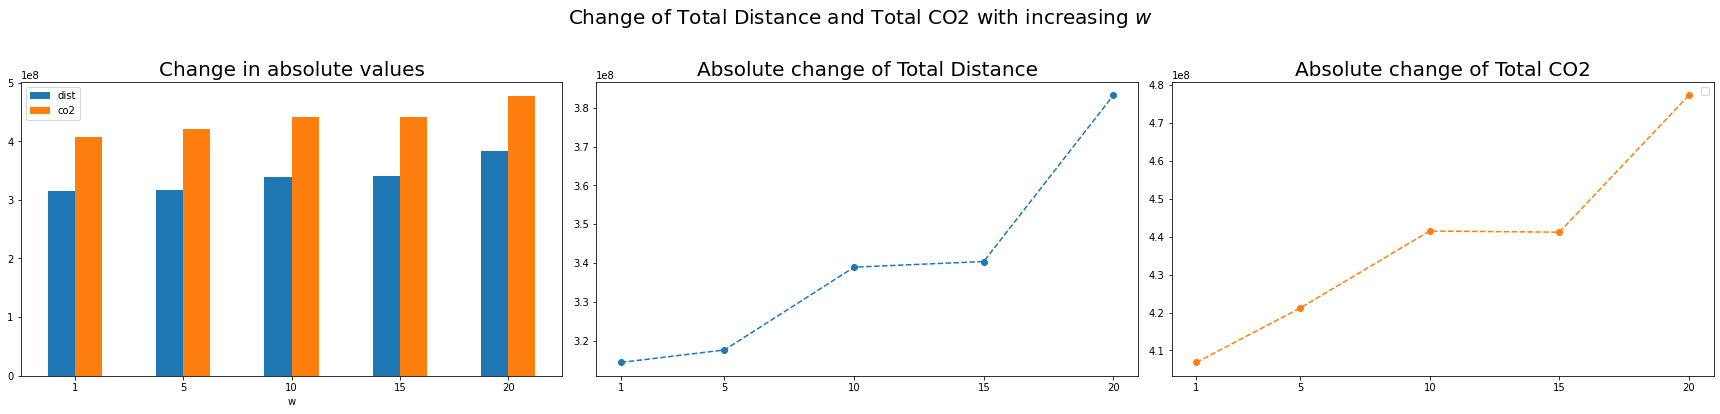

In [23]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(24, 20)) 
fig_dims = (3, 3)

#plotting the change in absolute values in a bar plot
ax = plt.subplot2grid(fig_dims, (0, 0))
tot_df.plot(x='w', y=['dist', 'co2'], kind='bar', rot=0, stacked=False, ax = ax)
ax.set_title('Change in absolute values', fontsize = 20)

#plotting the change of tot distance
ax2 = plt.subplot2grid(fig_dims, (0, 1))
ax2.plot(w_list, tot_df['dist'], marker = 'o', linestyle = '--', color = 'C0')
ax2.set_title('Absolute change of Total Distance', fontsize = 20)
ax2.set_xticks(w_list)

#plotting the change of tot co2
ax3 = plt.subplot2grid(fig_dims, (0, 2))
ax3.plot(w_list, tot_df['co2'], marker = 'o', linestyle = '--', color = 'C1')
ax3.set_title('Absolute change of Total CO2', fontsize = 20)
ax3.set_xticks(w_list)
plt.legend()

plt.suptitle('Change of Total Distance and Total CO2 with increasing $w$', fontsize = 20)

fig.tight_layout(rect=[0, 0.25, 1, 0.95])

In [24]:
#difference distances from the shortest path for each distance at w
list(zip(w_list, tot_df['delta_from_shortest'].values.tolist()))

[(1, 0.0),
 (5, 3217174.381939471),
 (10, 24556672.6967507),
 (15, 26007364.12483555),
 (20, 68872302.56375408)]

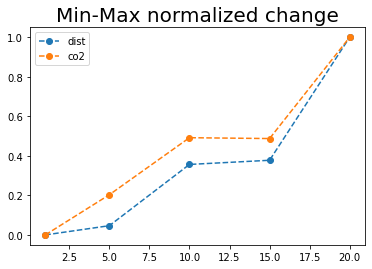

In [25]:
from sklearn.preprocessing import MinMaxScaler

# I just wanted to visualize the difference in the curves (which are positively correlated obviously)
scaled_values = MinMaxScaler().fit_transform(tot_df[['dist', 'co2']])

plt.plot(w_list, scaled_values[:,0], marker = 'o', linestyle = '--', color = 'C0', label = 'dist')
plt.plot(w_list, scaled_values[:,1], marker = 'o', linestyle = '--', color = 'C1', label = 'co2')
plt.title('Min-Max normalized change', fontsize = 20)
plt.legend()
plt.show()

# Conclusion
With a higher perturbation of the trajectories we get on average higher values of total distances and co2 as expected